In [1]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
Nside_red=16
Nside=512
lmax=3*Nside_red-1
l_gen=4*Nside
#pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
#pars.InitPower.set_params(As=2e-9, ns=0.965, r

const=1.88 * 10**(-9)
tau=0.07
# In[4]:
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.32, ombh2=0.02237, omch2=0.1201, mnu=0.06, omk=0, tau=tau)
pars.InitPower.set_params(As=const*np.exp(2*tau), ns=0.9651, r=0)
pars.set_for_lmax(l_gen, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK',raw_cl=False)#spectra are multiplied by l*(l+1)/2pi
totCL=powers['total']
ls = np.arange(totCL.shape[0])
cl_obs=np.asarray(totCL[0:lmax,1])
ell = np.arange(0,lmax+1)
print(totCL[0:lmax,0])

[   0.            0.         1055.39054813  998.02416127  941.8161874
  898.8048307   868.47941242  848.45682177  835.86606926  829.14586427
  826.84283639  827.50723751  831.73053628  837.42438957  844.49178958
  851.82136131  861.15250809  872.31061554  884.12665175  897.33317683
  910.29934388  923.72953624  937.65997586  951.68744441  966.11367456
  981.07517331  996.08772693 1011.55851052 1027.31549678 1043.28407424
 1059.66461827 1075.85494474 1092.66208129 1109.55497711 1126.50707388
 1144.08451285 1161.37479913 1178.91395429 1196.82138488 1214.99857484
 1233.36124054 1251.82052714 1270.38071674 1289.05637672 1307.89921702
 1326.97580499 1346.2539995 ]


In [2]:
f_ = np.load('/home/amorelli/cl_generator/outfile_0.npz')
#https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html if i have multiple npz files

print(f_.files) #give the keywords for the stored arrays
data_in=f_["data"]
tau_in=f_["tau"]
print(data_in.shape)
#print(data[:15,0,2])
data=data_in[:]
tau=tau_in[:]

['data', 'tau']
(1100, 4, 47)


In [3]:
high_nside = 512
low_nside= 16
window=hp.pixwin(low_nside,lmax=lmax, pol=False)
res=hp.nside2resol(low_nside)#, arcmin=False) #false give output in radians
beam=hp.gauss_beam(2*res, lmax=lmax, pol=False)
res_low=hp.nside2resol(low_nside)#, arcmin=False) 
#res_high=hp.nside2resol(high_nside, arcmin=False)
n_pix=hp.nside2npix(low_nside)
#print(res_low,res_high,n_pix)
sensitivity=5.7/2**0.25 #muK-arcmin
mu, sigma = 0, sensitivity*np.deg2rad(1./60.)/res
#Nl=(sigma*hp.nside2resol(512))**2
#print(res_low,hp.nside2resol(16))
Nl=(sensitivity*np.deg2rad(1.0/60.0))**2
#print(beam.shape)
smooth=beam*window
print(2*hp.nside2resol(low_nside,arcmin=True))

439.74226071262797


In [4]:
#i prepare the data
#print(cl_obs)
#print(data[0,0,:])
def normalize_cl(input_cl):
    output_cl=np.zeros(len(input_cl))
    for i in range(1,len(input_cl)):
        output_cl[i]=input_cl[i]/i/(i+1)*2*np.pi
    return output_cl
    

In [5]:
all_cl=np.zeros((len(tau)+1, lmax))
all_cl[0]=normalize_cl(cl_obs)*(smooth[:lmax])**2+Nl#*ell[:lmax]*(ell[:lmax]+1)/2/np.pi
for i in range(1,len(tau)+1):
    d=data[i-1,1,:]
    all_cl[i]=normalize_cl(d)*(smooth[:lmax])**2+Nl#*ell[:lmax]*(ell[:lmax]+1)/2/np.pi
print(all_cl.shape)
#print(tau[:2],all_cl[:3])

(1101, 47)


In [6]:
def compute_likelihood(c_obs,c_th,l): #cl_th wants all the cl for all the tau
    cl_obs=c_obs[l]
    cl_th=c_th[:,l]
    cl_obs*=1#*l*(l+1)/2/np.pi
    logL=np.zeros(len(cl_th))
    const=30
    #L_l becomes L_l*e^const
    for i,cl in enumerate(cl_th):
        #print(cl_obs,cl)
        #print(cl)
        cl_r=cl#*l*(l+1)/2/np.pi
        #print(cl_r)
        logL_i=-(2*l+1)/2*((cl_obs/cl_r)+np.log(np.abs(cl_r))-1-np.log(np.abs(cl_obs)))
        #print(np.log(np.abs(cl_r)),logL_i)
        #logL_i=-(2*l+1)/2*((cl/cl_obs)+np.log(np.abs(cl_obs)))
        logL[i]=logL_i
    return(logL)
logL=0
l=lmax
#c=10**90
for l in ell[2:l]:
    logL+=compute_likelihood(all_cl[0],all_cl[1:],l)
L_l=np.exp(logL)
print(logL)

[  -8.46134868  -65.95098578   -0.48462295 ...  -56.29003664 -106.00804851
  -50.32090048]


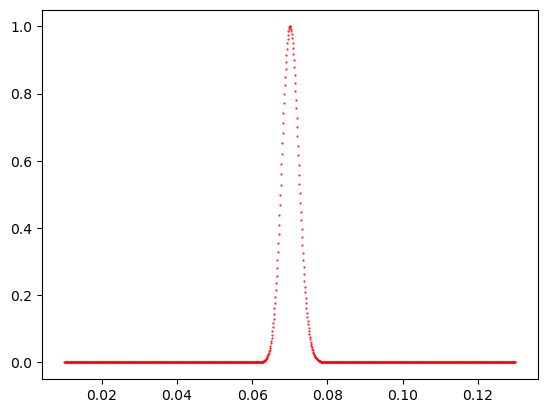

In [7]:
plt.plot(tau,L_l,color='r',linestyle='None',marker='.', markersize = 1.0)

In [8]:
#L_l=(L_l-np.mean(L_l))/np.std(L_l)
#plt.plot(tau,L_l,color='r',linestyle='None',marker='.', markersize = 1.0)
from scipy.integrate import trapz, simps
def unison_sorted_copies(a, b, c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = a.argsort()
    return a[p], b[p],c[p]
tau, L_l, logL=unison_sorted_copies(tau,L_l, logL)
print(tau)
#print(tau)

[0.01       0.01010919 0.01021838 ... 0.12978162 0.12989081 0.13      ]


In [9]:
A=trapz(L_l, tau)
print(A)
L_l=L_l/A
print(trapz(L_l, tau))
mean=trapz(L_l*tau, tau)
print(mean)
var=trapz(L_l*(tau-mean)**2,tau)
print(var)
sigma=var**0.5
print(sigma)

0.005588616059436117
1.0
0.07013855192529003
4.992362629012585e-06
0.002234359556788608


0.07013855192528816 0.0022343595567425717


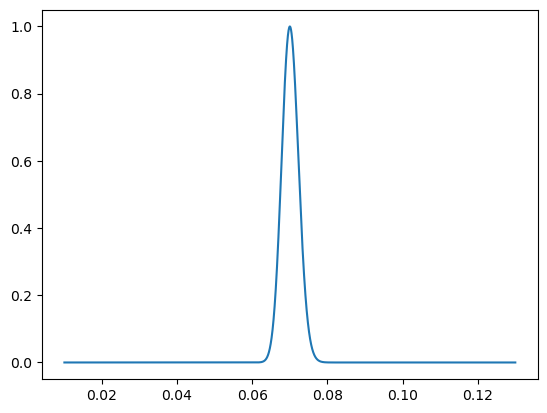

In [10]:
from scipy.interpolate import interp1d
tausover = np.linspace(0.01,0.13,100000)

likeover = interp1d(tau,logL,kind='cubic')(tausover)
probover = np.exp(likeover)

plt.plot(tausover,probover)

meantau = np.sum(probover*tausover)/np.sum(probover)
sigmatau = np.sqrt(np.sum(probover*tausover**2)/np.sum(probover) - meantau**2)
print(meantau,sigmatau)